In [181]:
!pip install peft
!pip install accelerate
!pip install bitsandBytes
!pip install transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [182]:
!pip install datasets

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [183]:
with open ("/kaggle/input/command-line-questions/data_for_finetuning.json", 'r') as f:
    for i in range(5):
        print(f.readline())

[

  {

    "instruction": "How do I undo the most recent local commits in Git?",

    "response": "Undo a commit & redo\n\n\n\n'''\n$ git commit -m \"Something terribly misguided\" # (0: Your Accident)\n$ git reset HEAD~                              # (1)\n# === If you just want to undo the commit, stop here! ===\n[ edit files as necessary ]                    # (2)\n$ git add .                                    # (3)\n$ git commit -c ORIG_HEAD                      # (4)\n'''\n\n\n\n\n\ngit reset\n is the command responsible for the \nundo\n. It will undo your last commit while \nleaving your working tree (the state of your files on disk) untouched.\n You'll need to add them again before you can commit them again.\n\n\nMake corrections to \nworking tree\n files.\n\n\ngit add\n anything that you want to include in your new commit.\n\n\nCommit the changes, reusing the old commit message. \nreset\n copied the old head to \n.git/ORIG_HEAD\n; \ncommit\n with \n-c ORIG_HEAD\n will open an 

In [184]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch

model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4"  
)

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map={"": 0}  # 0 not autoo
)

In [185]:
from datasets import load_dataset

dataset = load_dataset("json", data_files="/kaggle/input/command-line-questions/data_for_finetuning.json", split="train")

In [186]:
def format_json_to_txt(example):
    return {
        "text": f"### Instruction:\n{example['instruction']}\n\n### Response:\n{example['response']}"
    }

In [187]:
format_dataset= dataset.map(format_json_to_txt)

In [188]:
print(dataset.column_names)

['instruction', 'response']


In [ ]:
def tokenize(example):
    prompt = f"### Instruction:\n{example['instruction']}\n\n### Response:\n{example['response']}"
    tokenized = tokenizer(
        prompt,
        truncation=True,
        padding='max_length',
        max_length=512
    )
    tokenized["labels"] = tokenized["input_ids"].copy()  
    return tokenized 

In [190]:
tokenized_dataset = dataset.map(
    tokenize,
    remove_columns=dataset.column_names
)
tokenized_dataset.set_format("torch") 

In [ ]:
from peft import prepare_model_for_kbit_training

model = prepare_model_for_kbit_training(model)

from peft import LoraConfig, get_peft_model
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"], 
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, lora_config)

In [192]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [193]:
print("Trainer using device:", training_args.device)
print("Model on device:", next(model.parameters()).device)

Trainer using device: cuda:0
Model on device: cuda:0


In [194]:
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorForSeq2Seq


data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    padding=True,
    return_tensors="pt"
)

training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=1,
    num_train_epochs=1,
    logging_steps=10,
    save_steps=100,
    save_total_limit=2,
    report_to="none",
    fp16=False,
    optim="paged_adamw_8bit"
)
trainer = Trainer(
    model=model.to("cuda"),
    args=training_args,
    train_dataset=tokenized_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorForSeq2Seq(tokenizer, padding=True, return_tensors="pt")
)

/tmp/ipykernel_35/3273063585.py:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [195]:
trainer.train()

/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
10,2.242000
20,2.639600
30,2.513700
40,1.415100
50,1.398800
60,1.031000
70,0.857900


TrainOutput(global_step=75, training_loss=1.6817444165547688, metrics={'train_runtime': 115.3997, 'train_samples_per_second': 1.3, 'train_steps_per_second': 0.65, 'total_flos': 477741396787200.0, 'train_loss': 1.6817444165547688, 'epoch': 1.0})

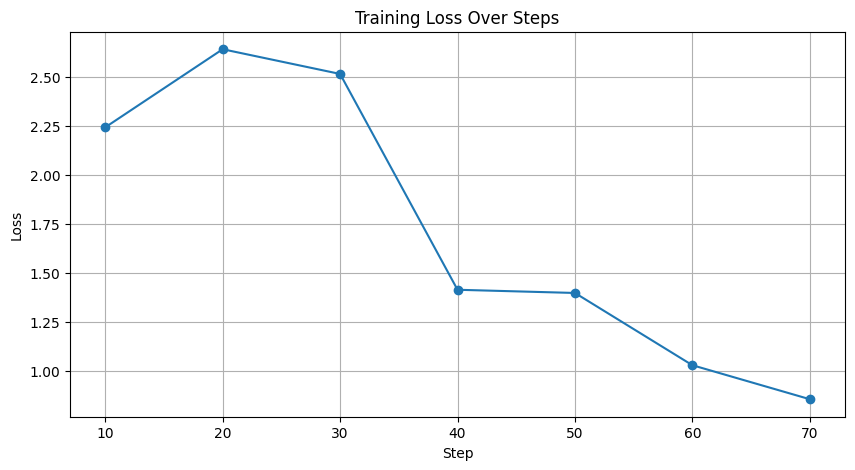

In [196]:
import matplotlib.pyplot as plt

# Get the training loss logs
log_history = trainer.state.log_history

# Extract steps and corresponding losses
steps = [log["step"] for log in log_history if "loss" in log]
losses = [log["loss"] for log in log_history if "loss" in log]

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(steps, losses, marker='o', linestyle='-')
plt.title("Training Loss Over Steps")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [197]:
model.save_pretrained("/kaggle/working/my_finetuned_model")
tokenizer.save_pretrained("/kaggle/working/my_finetuned_model")
!zip -r /kaggle/working/my_finetuned_model.zip /kaggle/working/my_finetuned_model

updating: kaggle/working/my_finetuned_model/ (stored 0%)
updating: kaggle/working/my_finetuned_model/tokenizer_config.json (deflated 68%)
updating: kaggle/working/my_finetuned_model/tokenizer.model (deflated 55%)
updating: kaggle/working/my_finetuned_model/tokenizer.json

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 (deflated 85%)
updating: kaggle/working/my_finetuned_model/README.md (deflated 66%)
updating: kaggle/working/my_finetuned_model/special_tokens_map.json (deflated 79%)
updating: kaggle/working/my_finetuned_model/adapter_model.safetensors (deflated 8%)
updating: kaggle/working/my_finetuned_model/adapter_config.json (deflated 54%)


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel, PeftConfig
import torch

peft_model_path = "/kaggle/input/modelfine/kaggle/working/my_finetuned_model"  

peft_config = PeftConfig.from_pretrained(peft_model_path)

base_model = AutoModelForCausalLM.from_pretrained(
    peft_config.base_model_name_or_path,
    torch_dtype=torch.float32,
    device_map=None
)

model = PeftModel.from_pretrained(base_model, peft_model_path).to("cpu")
tokenizer = AutoTokenizer.from_pretrained(peft_model_path)